In [16]:
import tensorflow as tf

介绍一些常用的稍微复杂的功能函数

参考：
1. <https://www.cnblogs.com/nxf-rabbit75/p/11276195.html>

## 1.`tf.gather`
`tf.gather(params, indices, validate_indices=None, name=None, axis=0)`

根据提供的indices在axis这个轴上对params进行索引，拼接成一个新的张量。
* params：需要被索引的张量
* indices：必须为整数类型，如int32,int64等，注意检查不要越界了，因为如果越界了，如果使用的CPU，则会报错，如果在GPU上进行操作的，那么相应的输出值将会被置为0，而不会报错，因此认真检查是否越界。
* name：返回张量名称

![](https://github.com/zfhxi/Learn_tensorflow/blob/master/ch05-TensorFlow%e8%bf%9b%e9%98%b6/img/04.png?raw=true)

In [17]:
x=tf.random.uniform([4,35,8],maxval=100,dtype=tf.int32) # 4个班级，35个学生，8门科目
# 收集1-2个班的成绩册
gather_x=tf.gather(x,[0,1],axis=0)
print(gather_x.shape)

(2, 35, 8)


上述操作可通过`x[:2]`切片操作简单实现，但对于不规则的索引方式，切片方式相当麻烦，而tf.gather优势便在于此。

In [18]:
# 收集1,4,9,12,13,27号同学的成绩
gather_x=tf.gather(x,[x-1 for x in [1,4,9,12,13,27]],axis=1)
print(gather_x.shape)
# 收集第3,5科目的成绩
gather_x=tf.gather(x,[2,4],axis=2)
print(gather_x.shape)

(4, 6, 8)
(4, 35, 2)


`tf.gather`非常适合于索引号没有规则的场合，其中索引号可以乱序排序：

In [19]:
a=tf.range(8)
a=tf.reshape(a,[4,2])
print((a))
gather_a=tf.gather(a,[3,1,0,2],axis=0) # 等价于交换行
print(gather_a)

tf.Tensor(
[[0 1]
 [2 3]
 [4 5]
 [6 7]], shape=(4, 2), dtype=int32)
tf.Tensor(
[[6 7]
 [2 3]
 [0 1]
 [4 5]], shape=(4, 2), dtype=int32)


将问题复杂化，希望抽查第2-3班的第3，4，6，27号同学的科目成绩。通过组合tf.gather实现:

In [20]:
gather_x=tf.gather(tf.gather(x,[1,2],axis=0),[2,3,5,26],axis=1)
print(gather_x.shape)

(2, 4, 8)


## 2.`tf.gather_nd`
`tf.gather_nd(params,indices,name=None,batch_dims=0)`

类似于tf.gather，不过后者只能在一个维度上进行索引，而前者可以在多个维度上进行索引

* params：待索引输入张量
* indices：是嵌套List，List中的每个元素亦是List，表示每个维度采样的索引
  * 如希望采样$i$号班级,$j$个学生,$k$门科目的成绩，则可表达为`[...,[i,j,k],...]`，外层括号长度表示采样的个数，内层列表包含了每个采样样本的索引坐标
* name=None：操作的名称（可选）

将问题再复杂化，希望抽查第2个班的第2个同学的所有科目，第3个班的第3个同学的所有科目，第4个班的第4个同学的所有科目。实现方式：

In [21]:
# 手动提取并堆叠合并
x=tf.random.uniform([4,35,8],maxval=100,dtype=tf.int32) # 4个班级，35个学生，8门科目
gather_x=tf.stack([x[1,1],x[2,2],x[3,3]],axis=0)
print(gather_x.shape)

# 上面的操作手动串行采样，计算效率低
# 采用tf.gather_nd
gather_x=tf.gather_nd(x,[[1,1],[2,2],[3,3]])
print(gather_x.shape)

(3, 8)
(3, 8)


抽查班级1的学生1的科目2、班级2的学生2的科目3、班级3的学生3的科目4的成绩,共有3个成绩数据,结果汇总:

In [22]:
gather_result=tf.gather_nd(x,[[1,1,2],[2,2,3],[3,3,4]])
print(gather_result.shape)

(3,)


## 3.`tf.boolean_mask`

除了上述的给定索引进行采样，也可通过给定掩码进行采样

`tf.boolean_mask(x,mask,axis)`可在axis轴上根据mask方案进行采样

* 掩码长度应与对应维度的长度一致，如对班级进行采样，那么掩码长度应和班级数一致(如下例)

In [23]:
x=tf.random.uniform([4,35,8],maxval=100,dtype=tf.int32) # 4个班级，35个学生，8门科目
# 采样第1个和第4个班级的数据
result=tf.boolean_mask(x,mask=[True,False,False,True],axis=0)
print(result.shape)

(2, 35, 8)


不难发现，与`tf.gather`很相似，只是给定索引换成了给定掩码。

考虑类似`tf.gather_nd`的多维度掩码采样，为方便演示，设定2个班级，每个班级3个学生

In [24]:
x=tf.random.uniform([2,3,8],maxval=100,dtype=tf.int32)
# 采样第1班的1-2号学生，2班的2-3号学生
result1=tf.gather_nd(x,[[0,0],[0,1],[1,1],[1,2]])
print(result1)

tf.Tensor(
[[63 98 38 19 65 83 57  2]
 [65 82 71 35 88 14 68 60]
 [94 11 33 89  7 82 51 51]
 [75 86 69 88 47 64 71 47]], shape=(4, 8), dtype=int32)


掩码方式如何实现？

下表列出了采样情况:

![](https://github.com/zfhxi/Learn_tensorflow/blob/master/ch05-TensorFlow%e8%bf%9b%e9%98%b6/img/05.png?raw=true)

通过此表，便明白了掩码方案：

In [25]:
result2=tf.boolean_mask(x,[[True,True,False],[False,True,True]])
print(result2)

tf.Tensor(
[[63 98 38 19 65 83 57  2]
 [65 82 71 35 88 14 68 60]
 [94 11 33 89  7 82 51 51]
 [75 86 69 88 47 64 71 47]], shape=(4, 8), dtype=int32)


## 4.`tf.where`

1. `tf.where(condition)`
  * condition是bool型值，True/False
  * 返回值，是condition中元素为True对应的索引
2. `tf.where(condition, x=None, y=None, name=None)`
    * condition， x, y 相同维度，condition是bool型值，True/False
    * 返回值是对应元素，condition中元素为True的元素替换为x中的元素，为False的元素替换为y中对应元素
    * x只负责对应替换True的元素，y只负责对应替换False的元素，x，y各有分工
    * 由于是替换，返回值的维度，和condition，x ， y都是相等的。

In [26]:
condition=[[True,False,False],
           [False,True,True],
           [True,True,False]]
result=tf.where(condition)
print(result)
A=tf.ones([3,3])
B=tf.zeros([3,3])
result1=tf.where(condition,A,B)
print(result1)

tf.Tensor(
[[0 0]
 [1 1]
 [1 2]
 [2 0]
 [2 1]], shape=(5, 2), dtype=int64)
tf.Tensor(
[[1. 0. 0.]
 [0. 1. 1.]
 [1. 1. 0.]], shape=(3, 3), dtype=float32)


用途？考虑场景，提取张量中所有正数的数据和索引：

In [27]:
x=tf.random.normal([3,3])
# 得到正数掩码
mask=x>0
# 提取所有大于0的元素索引
indices=tf.where(mask)
# 使用tf.gather_nd得到所有正数的元素
result2=tf.gather_nd(x,indices)
print(x)
print(mask)
print(indices)
print(result2)

# 或者在得到mask后直接使用tf.boolean_mask获取元素
result3=tf.boolean_mask(x,mask=mask)
print(result3)

tf.Tensor(
[[-1.0058336  -0.5472079   0.28864366]
 [-1.0228276   0.13646765  0.7407832 ]
 [-0.3122578   1.1740584  -0.1288489 ]], shape=(3, 3), dtype=float32)
tf.Tensor(
[[False False  True]
 [False  True  True]
 [False  True False]], shape=(3, 3), dtype=bool)
tf.Tensor(
[[0 2]
 [1 1]
 [1 2]
 [2 1]], shape=(4, 2), dtype=int64)
tf.Tensor([0.28864366 0.13646765 0.7407832  1.1740584 ], shape=(4,), dtype=float32)
tf.Tensor([0.28864366 0.13646765 0.7407832  1.1740584 ], shape=(4,), dtype=float32)


## 5.`scatter_nd`

`tf.scatter_nd(indices,updates,shape)`从全0的白板数据中对指定位置刷新数据为指定值
* indices，待刷新的数据索引
* updates，待填充的数据
* shape，指定白板的形状

下图是刷新过程的示意：

![](https://github.com/zfhxi/Learn_tensorflow/blob/master/ch05-TensorFlow%e8%bf%9b%e9%98%b6/img/06.png?raw=true)

In [28]:
# 构造刷新位置参数4,3,1,7号位置
indices=tf.constant([[4],[3],[1],[7]])
# 构造刷新位置对应的刷新数据
updates=tf.constant([4.4,3.3,1.1,7.7])
# 在长度为8的全0向量上刷新
out=tf.scatter_nd(indices,updates,[8])
print(out)

tf.Tensor([0.  1.1 0.  3.3 4.4 0.  0.  7.7], shape=(8,), dtype=float32)


考虑3维张量的例子: 白板张量的shape为\[4,4,4\]，共有4个通道的特征图，每个通道大小为4x4，现有2个通道的新数据updates: \[2,4,4\]，需要写入索引为\[1,3\]的通道上

![](https://github.com/zfhxi/Learn_tensorflow/blob/master/ch05-TensorFlow%e8%bf%9b%e9%98%b6/img/07.png?raw=true)

In [29]:
indices=tf.constant([[1],[3]])
# 构造写入数据，即2个矩阵
updates=tf.constant([
   [[5,5,5,5],[6,6,6,6],[7,7,7,7],[8,8,8,8]],
    [[1,1,1,1],[2,2,2,2],[3,3,3,3],[4,4,4,4]]
])
# 在白板上写入
out=tf.scatter_nd(indices=indices,updates=updates,shape=[4,4,4])
print(out)

tf.Tensor(
[[[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[5 5 5 5]
  [6 6 6 6]
  [7 7 7 7]
  [8 8 8 8]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[1 1 1 1]
  [2 2 2 2]
  [3 3 3 3]
  [4 4 4 4]]], shape=(4, 4, 4), dtype=int32)


## 6.`meshgrid`

通过`tf.meshgrid`函数可以方便地生成二维网络的采样点坐标，方便可视化等场合

考虑如下表达式：

$$z=\frac{\mathrm{sin}(x^2+y^2)}{x^2+y^2}$$

如需绘制在$x\in[-8,8],y\in[-8,8]$区间的sinc函数的3D曲面,

![](https://github.com/zfhxi/Learn_tensorflow/blob/master/ch05-TensorFlow%e8%bf%9b%e9%98%b6/img/07.png?raw=true)

则首先应生成x和y的网格坐标集合${(x,y)}$，在通过表达式计算z的值。可通过如下方式生产1万个坐标：

In [30]:
import math
def my_sinc(x,y):
    if not isinstance(x,tf.Tensor):
        m_out=math.sqrt(x**2+y**2)
        return math.sin(m_out)/m_out
    m_out=tf.sqrt(x**2+y**2)
    return tf.sin(m_out)/m_out
points=list()
for x in range(-8,8,100):
    for y in range(-8,8,100):
        z=my_sinc(x,y)
        points.append(([x,y,z]))

显然，这种方式效率极低。使用`tf.meshgrid`，先在x轴上采样100个点，y轴上采样100个点，然后利用`tf.meshgrid(x,y)`即可返回这个10000个数据点的张量数据，保存在shape为\[100,100,2\]的张量中。

2表示返回两个张量A和B，A包含了所有点的x坐标，B包含了所有点的y坐标

具体实现如下：

In [31]:
x=tf.linspace(-8.,8,100) # x轴采样
y=tf.linspace(-8.,8,100) # y轴采样
X,Y=tf.meshgrid(x,y)
Z=my_sinc(X,Y)
print(X.shape)
print(Y.shape)
print(Z.shape)

(100, 100)
(100, 100)
(100, 100)


使用matplotlib画出曲面

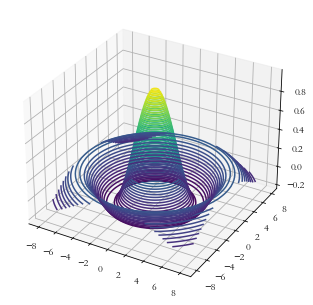

In [32]:
from matplotlib import pyplot as plt
# 导入3D坐标轴支持
from mpl_toolkits.mplot3d import Axes3D

fig=plt.figure()
ax=Axes3D(fig) # 设置3D坐标轴
# 根据网格点绘制sinc函数3D曲面
ax.contour3D(X.numpy(),Y.numpy(),Z.numpy(),50)
plt.show()

In [ ]:
import os
pid=os.getpid()
!kill -9 $pid